### Задание
Проведите эксперименты по начальному обучению различных моделей и сравните результаты.

Возьмите датасет EMNIST из torchvision.  
Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161:
желательно обучить каждую модель с нуля по 10 эпох   
если ресурсов компьютера / Colab не хватает, достаточно обучить каждую модель по 1-2 эпохи  
Сведите результаты обучения моделей (графики лосса) в таблицу и сравните их.   

#### Инструкция к выполнению задания

1. Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
2. Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
3. Обучите модель с нуля до 1-10 эпох — количество эпох выбираете сами в зависимости от вычислительных ресурсов. Фиксируйте значение функции потерь в список для последующего отображения.
4. Повторите пункты 2 и 3 для всех указанных вариантов моделей.

In [155]:
import matplotlib.pyplot as plt
import torchvision as tv
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchsummary import summary
import time

In [156]:
transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.EMNIST('.', split ='balanced', download = True, train = True, transform = transform)
data_test = datasets.EMNIST('.', split ='balanced', download = True, train = False, transform = transform)

In [157]:
traindata = DataLoader(data_train, batch_size = 100, shuffle = True)
testdata = DataLoader(data_test, batch_size = 100, shuffle = True)

In [4]:
dataiter = iter(traindata)
data = next(dataiter)
features, labels = data

In [5]:
print('Размер изображения', features[0].shape)

Размер изображения torch.Size([1, 28, 28])


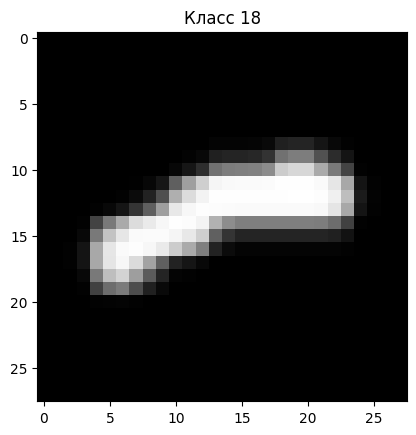

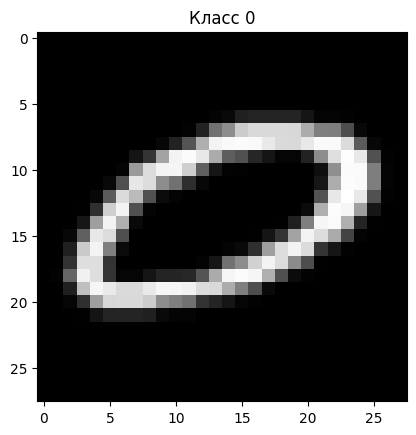

In [6]:
plt.imshow(torch.squeeze(features[0]), cmap = 'gray')
plt.title('Класс '+ str(labels[0].item()))
plt.show()
plt.imshow(torch.squeeze(features[40]), cmap = 'gray')
plt.title('Класс '+ str(labels[40].item()))
plt.show()

In [7]:
from collections import defaultdict
class_dict = defaultdict(list)
for f, l in traindata:
    digits, cnt = torch.unique(l, return_counts=True)[0].numpy(), torch.unique(l, return_counts=True)[1].numpy()
    for digit in zip(digits, cnt):
        class_dict[digit[0]].append(digit[1])

In [8]:
count_sample = {}
for k, v in class_dict.items():
    count_sample[k] = sum(v)

count_sample

{0: 2400,
 1: 2400,
 2: 2400,
 3: 2400,
 4: 2400,
 5: 2400,
 6: 2400,
 7: 2400,
 8: 2400,
 9: 2400,
 10: 2400,
 11: 2400,
 12: 2400,
 13: 2400,
 15: 2400,
 16: 2400,
 17: 2400,
 18: 2400,
 19: 2400,
 20: 2400,
 21: 2400,
 22: 2400,
 24: 2400,
 25: 2400,
 26: 2400,
 27: 2400,
 28: 2400,
 29: 2400,
 30: 2400,
 31: 2400,
 32: 2400,
 33: 2400,
 34: 2400,
 35: 2400,
 36: 2400,
 37: 2400,
 38: 2400,
 39: 2400,
 41: 2400,
 42: 2400,
 43: 2400,
 44: 2400,
 46: 2400,
 14: 2400,
 23: 2400,
 40: 2400,
 45: 2400}

In [9]:
len(count_sample)

47

#### Ожидаемо, как и задавала в параметрах датасета - классы сбалансированы

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [12]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [158]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', train=True, split ='balanced', transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', train=False, split ='balanced', transform=transoforms, download=True)

In [159]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [17]:
model = tv.models.resnet18(pretrained=True)
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [19]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [20]:
model.fc = nn.Linear(in_features=512, out_features=47)

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [21]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)
train(model, train_iter, test_iter, trainer, 1)

Step 0. time since epoch: 1.644. Train acc: 0.016. Train Loss: 4.065
Step 10. time since epoch: 8.523. Train acc: 0.057. Train Loss: 3.726
Step 20. time since epoch: 15.916. Train acc: 0.144. Train Loss: 3.499
Step 30. time since epoch: 22.678. Train acc: 0.213. Train Loss: 3.295
Step 40. time since epoch: 29.987. Train acc: 0.267. Train Loss: 3.127
Step 50. time since epoch: 37.002. Train acc: 0.315. Train Loss: 2.977
Step 60. time since epoch: 44.170. Train acc: 0.351. Train Loss: 2.845
Step 70. time since epoch: 51.506. Train acc: 0.387. Train Loss: 2.725
Step 80. time since epoch: 58.315. Train acc: 0.412. Train Loss: 2.620
Step 90. time since epoch: 65.731. Train acc: 0.435. Train Loss: 2.522
Step 100. time since epoch: 72.732. Train acc: 0.456. Train Loss: 2.437
Step 110. time since epoch: 80.158. Train acc: 0.473. Train Loss: 2.360
Step 120. time since epoch: 87.168. Train acc: 0.488. Train Loss: 2.292
Step 130. time since epoch: 94.392. Train acc: 0.500. Train Loss: 2.230
Step 

In [25]:
pv_table = {}
pv_table['resnet18'] = {'epoch': 1, 'loss': 1.4135, 'train_acc': 0.659, 'test_acc': 0.758}
pv_table

{'resnet18': {'epoch': 1,
  'loss': 1.4135,
  'train_acc': 0.659,
  'test_acc': 0.758}}

In [28]:
model = tv.models.vgg16(pretrained=True)
model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [36]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [37]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=47)

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [38]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)
train(model, train_iter, test_iter, trainer, 1)

Step 0. time since epoch: 2.134. Train acc: 0.031. Train Loss: 3.903
Step 10. time since epoch: 19.687. Train acc: 0.110. Train Loss: 3.535
Step 20. time since epoch: 37.374. Train acc: 0.200. Train Loss: 3.230
Step 30. time since epoch: 55.217. Train acc: 0.258. Train Loss: 2.991
Step 40. time since epoch: 72.405. Train acc: 0.296. Train Loss: 2.825
Step 50. time since epoch: 90.473. Train acc: 0.325. Train Loss: 2.687
Step 60. time since epoch: 108.156. Train acc: 0.347. Train Loss: 2.581
Step 70. time since epoch: 125.827. Train acc: 0.367. Train Loss: 2.488
Step 80. time since epoch: 142.955. Train acc: 0.384. Train Loss: 2.406
Step 90. time since epoch: 160.526. Train acc: 0.399. Train Loss: 2.334
Step 100. time since epoch: 178.667. Train acc: 0.413. Train Loss: 2.272
Step 110. time since epoch: 196.117. Train acc: 0.425. Train Loss: 2.217
Step 120. time since epoch: 213.603. Train acc: 0.434. Train Loss: 2.171
Step 130. time since epoch: 231.033. Train acc: 0.441. Train Loss: 2.

In [39]:
pv_table['vgg16'] = {'epoch': 1, 'loss': 1.6052, 'train_acc': 0.552, 'test_acc': 0.711}
pv_table

{'resnet18': {'epoch': 1,
  'loss': 1.4135,
  'train_acc': 0.659,
  'test_acc': 0.758},
 'vgg16': {'epoch': 1, 'loss': 1.6052, 'train_acc': 0.552, 'test_acc': 0.711}}

In [145]:
model = tv.models.inception_v3(pretrained=True)
model.cuda()
model.aux_logits = False

In [146]:
summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [147]:

BATCH_SIZE = 256
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

In [148]:
train_dataset = tv.datasets.EMNIST('.', train=True, split ='balanced', transform=transforms, download=True)
test_dataset = tv.datasets.EMNIST('.', train=False, split ='balanced', transform=transforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [149]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [150]:
model.fc = nn.Linear(in_features=2048, out_features=47)

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [151]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)
train(model, train_iter, test_iter, trainer, 1)

Step 0. time since epoch: 1.982. Train acc: 0.008. Train Loss: 3.881
Step 10. time since epoch: 22.620. Train acc: 0.055. Train Loss: 3.764
Step 20. time since epoch: 42.920. Train acc: 0.114. Train Loss: 3.624
Step 30. time since epoch: 63.997. Train acc: 0.162. Train Loss: 3.489
Step 40. time since epoch: 84.109. Train acc: 0.198. Train Loss: 3.374
Step 50. time since epoch: 104.209. Train acc: 0.229. Train Loss: 3.267
Step 60. time since epoch: 124.467. Train acc: 0.252. Train Loss: 3.176
Step 70. time since epoch: 144.611. Train acc: 0.274. Train Loss: 3.092
Step 80. time since epoch: 164.566. Train acc: 0.293. Train Loss: 3.016
Step 90. time since epoch: 184.717. Train acc: 0.310. Train Loss: 2.942
Step 100. time since epoch: 204.554. Train acc: 0.325. Train Loss: 2.878
Step 110. time since epoch: 224.613. Train acc: 0.336. Train Loss: 2.820
Step 120. time since epoch: 244.454. Train acc: 0.347. Train Loss: 2.766
Step 130. time since epoch: 264.732. Train acc: 0.356. Train Loss: 2

In [152]:
pv_table['inception_v3'] = {'epoch': 1, 'loss': 2.0168, 'train_acc': 0.484, 'test_acc': 0.636}
pv_table

{'resnet18': {'epoch': 1,
  'loss': 1.4135,
  'train_acc': 0.659,
  'test_acc': 0.758},
 'vgg16': {'epoch': 1, 'loss': 1.6052, 'train_acc': 0.552, 'test_acc': 0.711},
 'inception_v3': {'epoch': 1,
  'loss': 2.0168,
  'train_acc': 0.484,
  'test_acc': 0.636}}

In [171]:
model = tv.models.densenet161(weights=True)

In [172]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [173]:

# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [174]:
model.classifier = nn.Linear(in_features=2208, out_features=47)

In [175]:

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [176]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [177]:
train(model, train_iter, test_iter, trainer, 1)

Step 0. time since epoch: 2.447. Train acc: 0.012. Train Loss: 3.905
Step 10. time since epoch: 25.232. Train acc: 0.119. Train Loss: 3.627
Step 20. time since epoch: 48.818. Train acc: 0.209. Train Loss: 3.368
Step 30. time since epoch: 72.832. Train acc: 0.278. Train Loss: 3.143
Step 40. time since epoch: 96.422. Train acc: 0.327. Train Loss: 2.963
Step 50. time since epoch: 119.898. Train acc: 0.370. Train Loss: 2.805
Step 60. time since epoch: 143.643. Train acc: 0.398. Train Loss: 2.678
Step 70. time since epoch: 167.328. Train acc: 0.424. Train Loss: 2.564
Step 80. time since epoch: 190.751. Train acc: 0.445. Train Loss: 2.464
Step 90. time since epoch: 214.326. Train acc: 0.465. Train Loss: 2.374
Step 100. time since epoch: 238.094. Train acc: 0.481. Train Loss: 2.294
Step 110. time since epoch: 261.766. Train acc: 0.496. Train Loss: 2.222
Step 120. time since epoch: 285.442. Train acc: 0.509. Train Loss: 2.158
Step 130. time since epoch: 309.119. Train acc: 0.521. Train Loss: 2

In [178]:
pv_table['densenet161'] = {'epoch': 1, 'loss': 1.3606, 'train_acc': 0.666, 'test_acc': 0.755}
pv_table

{'resnet18': {'epoch': 1,
  'loss': 1.4135,
  'train_acc': 0.659,
  'test_acc': 0.758},
 'vgg16': {'epoch': 1, 'loss': 1.6052, 'train_acc': 0.552, 'test_acc': 0.711},
 'inception_v3': {'epoch': 1,
  'loss': 2.0168,
  'train_acc': 0.484,
  'test_acc': 0.636},
 'densenet161': {'epoch': 1,
  'loss': 1.3606,
  'train_acc': 0.666,
  'test_acc': 0.755}}

In [180]:
pd.DataFrame(pv_table)

,resnet18,vgg16,inception_v3,densenet161
epoch,1.0000,1.0000,1.0000,1.0000
loss,1.4135,1.6052,2.0168,1.3606
train_acc,0.6590,0.5520,0.4840,0.6660
test_acc,0.7580,0.7110,0.6360,0.7550


наилучшую точность показали 2 архитектуры - resnet18 и densenet161.  
при этом время обучения resnet18 меньше чем densenet161 в 3.3 раза